## Here we will try our best shot to predict the goals with our features

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
%cd /content/gdrive/MyDrive/Master_UdeM/IFT-6758/Project/ift6758-project-main

/content/gdrive/MyDrive/Master_UdeM/IFT-6758/Project/ift6758-project-main


In [23]:
#!git clone https://GIT_TOKEN@github.com/M0rph3e/ift6758-project-main.git #not anymore
! git pull

Already up to date.


In [17]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ift6758/metrics/plot_metrics.py

no changes added to commit (use "git add" and/or "git commit -a")


In [24]:
!pip install comet_ml pandas_profiling

In [19]:
! git branch

  best_shot_trial
  fengineering2
* main


# Real **** starts from here

In [249]:
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.data.data_acquisition import Season
from ift6758.visualizations.simple_visualization import Utilities 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import random
import pandas as pd
import pickle
import sys
import json

import warnings
warnings.filterwarnings("ignore")

In [250]:
train_years = [2015,2016,2017]
valid_years = [2018]
test_years=[2019]


train_dataset = SeasonDataSetTwo(train_years)
valid_dataset = SeasonDataSetTwo(valid_years)
train_df = train_dataset.get_features_2()
valid_df = valid_dataset.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2015_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2015_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2016_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2016_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2017_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2017_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2018_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2018_period_info.pkl


In [251]:
test_data = SeasonDataSetTwo(test_years)
test_df = test_data.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2019_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2019_period_info.pkl


In [252]:
train_df.columns

Index(['result.penaltySeverity', 'result.penaltyMinutes', 'gamePk',
       'team.name', 'gamePeriod', 'coordinatesX', 'coordinatesY', 'shotType',
       'emptyNet', 'result.strength.name', 'gameSeconds', 'shotDistance',
       'shotAngle', 'isGoal', 'lastEventType', 'lastEventCoordinatesX',
       'lastEventCoordinatesY', 'timeFromLastEvent', 'distanceFromLastEvent',
       'rebound', 'speed', 'changeInShotAngle', 'angleSpeed'],
      dtype='object')

# Export the data csv to comet (do not execute for now)

In [69]:
from comet_ml import Experiment
import os



exp = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name='milestone-2',
    workspace='morph-e',
    log_code=True,
    log_graph=True,
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/morph-e/milestone-2/2de74906d5ad42c0913ded110a44d306



In [70]:
exp.log_dataframe_profile(
train_df, 
name='train_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
valid_df, 
name='valid_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
test_df, 
name='test_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)


COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring


{'dataframe': {'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=4a1ec1be94d641b6a9fdf5a03ed78719&experimentKey=2de74906d5ad42c0913ded110a44d306',
  'assetId': '4a1ec1be94d641b6a9fdf5a03ed78719',
  'web': 'https://www.comet.ml/api/asset/download?assetId=4a1ec1be94d641b6a9fdf5a03ed78719&experimentKey=2de74906d5ad42c0913ded110a44d306'},
 'profile': None}

# Split and shuffle Data

In [256]:
random.seed(42)

In [257]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
valid_df = valid_df.sample(frac=1)

In [258]:
train_df.head()

,result.penaltySeverity,result.penaltyMinutes,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,result.strength.name,gameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
232847,NaN,NaN,2017021135,Anaheim Ducks,2,-79.0,5.0,Backhand,False,Even,538.0,11.180340,26.565051,1,Hit,42.0,-39.0,5.0,128.751699,False,25.750340,0.000000,0.000000
225210,NaN,NaN,2017021016,Pittsburgh Penguins,3,37.0,31.0,Slap Shot,0,NaN,910.0,60.539243,-30.801446,0,Faceoff,69.0,22.0,5.0,33.241540,False,6.648308,0.000000,0.000000
237103,NaN,NaN,2017021202,Washington Capitals,1,-33.0,-23.0,Wrist Shot,0,NaN,188.0,60.539243,-22.328656,0,Hit,44.0,-19.0,6.0,77.103826,False,12.850638,0.000000,0.000000
149306,NaN,NaN,2016021149,Edmonton Oilers,3,78.0,-1.0,Tip-In,False,Even,471.0,11.045361,5.194429,1,Giveaway,78.0,10.0,2.0,11.000000,False,5.500000,0.000000,0.000000
65413,NaN,NaN,2015021090,Columbus Blue Jackets,1,-47.0,30.0,Wrist Shot,0,NaN,398.0,139.269523,-12.439562,0,Shot,-67.0,-35.0,24.0,68.007353,True,2.833640,25.084982,1.045208


In [260]:
features = ['gameSeconds','timeFromLastEvent','gamePeriod','shotType', 'shotAngle', 'shotDistance','distanceFromLastEvent', 'rebound','speed','changeInShotAngle']
label = ['isGoal']

In [261]:
train_df[features].isna().any()
valid_df[features].isna().any()
valid_df[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                  True
shotAngle                 True
shotDistance              True
distanceFromLastEvent     True
rebound                  False
speed                     True
changeInShotAngle        False
dtype: bool

### Replace inf with nan (annoying in normalization)

In [262]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [264]:
#drop rows with nan
train_df = train_df[train_df['shotType'].notna()]
valid_df = valid_df[valid_df['shotType'].notna()]
test_df = test_df[test_df['shotType'].notna()]

train_df = train_df[train_df['shotAngle'].notna()]
valid_df = valid_df[valid_df['shotAngle'].notna()]
test_df = test_df[test_df['shotAngle'].notna()]

train_df = train_df[train_df['shotDistance'].notna()]
valid_df = valid_df[valid_df['shotDistance'].notna()]
test_df = test_df[test_df['shotDistance'].notna()]

train_df = train_df[train_df['speed'].notna()]
valid_df = valid_df[valid_df['speed'].notna()]
test_df = test_df[test_df['speed'].notna()]

train_df = train_df[train_df['changeInShotAngle'].notna()]
valid_df = valid_df[valid_df['changeInShotAngle'].notna()]
test_df = test_df[test_df['changeInShotAngle'].notna()]
"""
train_df = train_df[train_df['coordinatesX'].notna()]
valid_df = valid_df[valid_df['coordinatesX'].notna()]
test_df = test_df[test_df['coordinatesX'].notna()]

train_df = train_df[train_df['coordinatesY'].notna()]
valid_df = valid_df[valid_df['coordinatesY'].notna()]
test_df = test_df[test_df['coordinatesY'].notna()]

train_df = train_df[train_df['lastEventCoordinatesY'].notna()]
valid_df = valid_df[valid_df['lastEventCoordinatesY'].notna()]
test_df = test_df[test_df['lastEventCoordinatesY'].notna()]

train_df = train_df[train_df['lastEventCoordinatesX'].notna()]
valid_df = valid_df[valid_df['lastEventCoordinatesX'].notna()]
test_df = test_df[test_df['lastEventCoordinatesX'].notna()]

train_df = train_df[train_df['angleSpeed'].notna()]
valid_df = valid_df[valid_df['angleSpeed'].notna()]
test_df = test_df[test_df['angleSpeed'].notna()]

"""

"\ntrain_df = train_df[train_df['coordinatesX'].notna()]\nvalid_df = valid_df[valid_df['coordinatesX'].notna()]\ntest_df = test_df[test_df['coordinatesX'].notna()]\n\ntrain_df = train_df[train_df['coordinatesY'].notna()]\nvalid_df = valid_df[valid_df['coordinatesY'].notna()]\ntest_df = test_df[test_df['coordinatesY'].notna()]\n\ntrain_df = train_df[train_df['lastEventCoordinatesY'].notna()]\nvalid_df = valid_df[valid_df['lastEventCoordinatesY'].notna()]\ntest_df = test_df[test_df['lastEventCoordinatesY'].notna()]\n\ntrain_df = train_df[train_df['lastEventCoordinatesX'].notna()]\nvalid_df = valid_df[valid_df['lastEventCoordinatesX'].notna()]\ntest_df = test_df[test_df['lastEventCoordinatesX'].notna()]\n\ntrain_df = train_df[train_df['angleSpeed'].notna()]\nvalid_df = valid_df[valid_df['angleSpeed'].notna()]\ntest_df = test_df[test_df['angleSpeed'].notna()]\n\n"

In [265]:
train_df[features].isna().any()
valid_df[features].isna().any()
valid_df[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                 False
shotAngle                False
shotDistance             False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
dtype: bool

In [267]:
X_train = train_df[features]
y_train = train_df[label]

X_valid = valid_df[features]
y_valid = valid_df[label]

X_test = test_df[features]
y_test = test_df[label]

X_train, y_train, X_valid, y_valid, X_test, y_test

(        gameSeconds  timeFromLastEvent  ...      speed changeInShotAngle
 232847        538.0                5.0  ...  25.750340          0.000000
 225210        910.0                5.0  ...   6.648308          0.000000
 237103        188.0                6.0  ...  12.850638          0.000000
 149306        471.0                2.0  ...   5.500000          0.000000
 65413         398.0               24.0  ...   2.833640         25.084982
 ...             ...                ...  ...        ...               ...
 127807         72.0               52.0  ...   0.461538          0.000000
 181160        964.0               28.0  ...   4.803405         59.646269
 148          1022.0                9.0  ...   3.446236          0.000000
 46159         407.0               43.0  ...   2.821918          0.000000
 233626       1141.0               16.0  ...   2.335193        151.357306
 
 [238046 rows x 10 columns],         isGoal
 232847       1
 225210       0
 237103       0
 149306       1
 6

### One Hot encode the shot type (I want to refer on the fact that the shot type affect the goal)

In [268]:
X_train['shotType'].unique()

array(['Backhand', 'Slap Shot', 'Wrist Shot', 'Tip-In', 'Snap Shot',
       'Deflected', 'Wrap-around'], dtype=object)

In [269]:
dum_train = pd.get_dummies(X_train['shotType'], prefix='Shot',dtype=int)
dum_valid = pd.get_dummies(X_valid['shotType'], prefix='Shot',dtype=int)
dum_test = pd.get_dummies(X_test['shotType'], prefix='Shot',dtype=int)

In [270]:
X_train = pd.concat([X_train, dum_train], axis=1)
X_valid = pd.concat([X_valid, dum_valid], axis=1)
X_test = pd.concat([X_test, dum_test], axis=1)

In [271]:
#check if no nans
X_train.isna().any(), X_valid.isna().any(), X_test.isna().any()

(gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotType                 False
 shotAngle                False
 shotDistance             False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           False
 Shot_Tip-In              False
 Shot_Wrap-around         False
 Shot_Wrist Shot          False
 dtype: bool, gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotType                 False
 shotAngle                False
 shotDistance             False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           F

In [272]:
X_train = X_train.drop(columns='shotType')
X_valid = X_valid.drop(columns='shotType')
X_test = X_test.drop(columns='shotType')

## Do the same for gamePeriod (**NOT NOW**)

In [198]:
#try smth because idk
X_train['gamePeriod'] -=1
X_valid['gamePeriod']-=1
X_test['gamePeriod']-=1

In [199]:
dum_train = pd.get_dummies(X_train['gamePeriod'], prefix='Period',dtype=int)
dum_valid = pd.get_dummies(X_valid['gamePeriod'], prefix='Period',dtype=int)
dum_test = pd.get_dummies(X_test['gamePeriod'], prefix='Period',dtype=int)

X_train = pd.concat([X_train, dum_train], axis=1)
X_valid = pd.concat([X_valid, dum_valid], axis=1)
X_test = pd.concat([X_test, dum_test], axis=1)

#check if no nans
X_train.isna().any(), X_valid.isna().any(), X_test.isna().any()

(gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotAngle                False
 shotDistance             False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           False
 Shot_Tip-In              False
 Shot_Wrap-around         False
 Shot_Wrist Shot          False
 Period_0                 False
 Period_1                 False
 Period_2                 False
 Period_3                 False
 Period_4                 False
 Period_5                 False
 dtype: bool, gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotAngle                False
 shotDistance             False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        F

In [200]:
#drop gamePeriod
X_train = X_train.drop(columns='gamePeriod')
X_valid = X_valid.drop(columns='gamePeriod')
X_test = X_test.drop(columns='gamePeriod')

# Change rebound feature

In [273]:
X_train['rebound'] = X_train['rebound'].astype(int)
X_valid['rebound'] = X_valid['rebound'].astype(int)
X_test['rebound'] = X_test['rebound'].astype(int)

In [274]:
X_test.head()

,gameSeconds,timeFromLastEvent,gamePeriod,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot
43376,934.0,11.0,2,-22.166346,58.309519,19.209373,1,1.746307,12.704024,0,0,1,0,0,0,0
74570,364.0,18.0,2,-10.885527,158.858428,8.246211,0,0.458123,0.000000,0,0,0,1,0,0,0
41311,621.0,1.0,1,-39.289407,14.212670,19.646883,1,19.646883,31.694763,0,0,0,0,0,0,1
30372,1166.0,13.0,2,-25.167870,91.706052,59.033889,0,4.541068,0.000000,0,0,0,1,0,0,0
15576,34.0,20.0,1,-32.319617,57.982756,50.606324,0,2.530316,0.000000,0,0,0,0,0,0,1


# Normalize numerical data 

#### Here I standardize the game period, but I shouldn't, but last time (check on best_shot_trial branch) **IT DID GOOD ON MY CERTAINTITY OF PREDICTION** so I'll keep it as a best shot lol

In [276]:
num = ['gameSeconds','timeFromLastEvent','shotAngle', 'shotDistance','distanceFromLastEvent','speed','changeInShotAngle']

In [277]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[num])

X_train[num] = scaler.transform(X_train[num])
X_valid[num] = scaler.transform(X_valid[num])
X_test[num] = scaler.transform(X_test[num])

In [278]:
X_test

,gameSeconds,timeFromLastEvent,gamePeriod,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot
43376,0.975593,-0.307472,2,-0.631713,0.574417,-0.928374,1,-0.619437,0.253149,0,0,1,0,0,0,0
74570,-0.661435,0.166103,2,-0.322478,3.736018,-1.165986,0,-0.747215,-0.363797,0,0,0,1,0,0,0
41311,0.076664,-0.984007,1,-1.101098,-0.812138,-0.918892,1,1.156169,1.175397,0,0,0,0,0,0,1
30372,1.641892,-0.172165,2,-0.713992,1.624519,-0.065233,0,-0.342217,-0.363797,0,0,0,1,0,0,0
15576,-1.609188,0.301410,1,-0.910039,0.564143,-0.247889,0,-0.541669,-0.363797,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30565,-0.299566,-0.781047,2,-0.044344,3.615102,-0.820496,0,-0.192870,-0.363797,0,0,0,0,1,0,0
59159,-1.247318,-0.713393,1,-0.298422,0.369360,-0.616142,0,-0.125776,-0.363797,0,0,1,0,0,0,0
19828,-1.281782,3.210513,1,0.064729,0.410136,-0.447413,0,-0.727473,-0.363797,0,0,1,0,0,0,0
36663,-0.423061,-0.307472,1,-1.567672,-0.011954,-0.877847,0,-0.598414,-0.363797,0,0,0,0,0,0,1


## Export your normalized set on comet

In [279]:
exp.log_dataframe_profile(
X_train, 
name='normalized_train_features',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
X_valid, 
name='normalized_valid_features',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
X_test, 
name='normalized_test_features',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)


# Try Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators':[50,65,80,100,115,130,150],
     'max_depth': [5,6,7,8,9,10,11,12,13,14,15,18]
}

rf = RandomForestClassifier(criterion='entropy')
sh = HalvingGridSearchCV(rf,param_grid, cv=4)
model = sh.fit(X_train,y_train)

In [ ]:
model.best_estimator_

In [ ]:
y_pred_valid  = model.predict(X_valid)

In [ ]:
y_proba_val = model.predict_proba(X_valid)[:,1] # get the proba of having a goal (pred=1)

In [ ]:
score_ = model.score(X_valid,y_valid)
score_

In [234]:
%matplotlib inline
plt.close('all')

# Export model on comet before plotting

In [221]:
weights_dir = "../ift6758/models/weights"
experiment = "Random-forest-with-FE2"
predscore_val_dict={}

In [108]:
!ls ..

ift6758  ift6758-project-main


In [222]:
import joblib

predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['true_valid_label']=y_valid
predscore_val_dict[experiment]['proba']=y_proba_val
predscore_val_dict[experiment]['prediction']=y_pred_valid

## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(model,filename)

['../ift6758/models/weights/Random-forest-with-FE2.pkl']

In [223]:
exp.log_model("Random Forest", "../ift6758/models/weights/Random-forest-with-FE2.pkl")

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=f92d1768268e485aa300d40ae9bcfcab&experimentKey=2de74906d5ad42c0913ded110a44d306',
 'assetId': 'f92d1768268e485aa300d40ae9bcfcab',
 'web': 'https://www.comet.ml/api/asset/download?assetId=f92d1768268e485aa300d40ae9bcfcab&experimentKey=2de74906d5ad42c0913ded110a44d306'}

# Plotting

In [111]:
# First we will switch branch, the plotting metrics are on main
!git checkout main

M	ift6758/metrics/plot_metrics.py
Already on 'main'
Your branch is up to date with 'origin/main'.


In [112]:
!git branch

  best_shot_trial
  fengineering2
* main


In [113]:
!git pull

Already up to date.


              precision    recall  f1-score   support

           0       0.91      1.00      0.95    216808
           1       1.00      0.03      0.06     21238

    accuracy                           0.91    238046
   macro avg       0.96      0.52      0.51    238046
weighted avg       0.92      0.91      0.87    238046



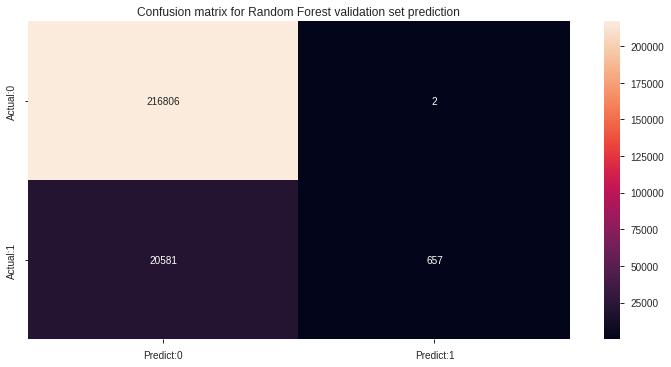

In [224]:
from ift6758.metrics import plot_metrics

plot_metrics.plotConfusion(y_valid,y_pred_valid, title='Confusion matrix for Random Forest validation set prediction')

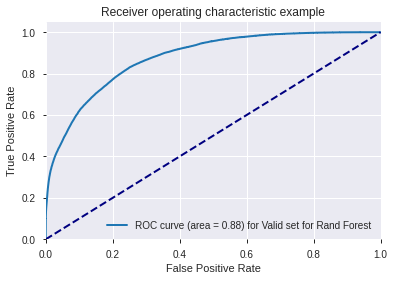

In [225]:
plot_metrics.plot_roc([y_valid],[y_proba_val],["Valid set for Rand Forest"])

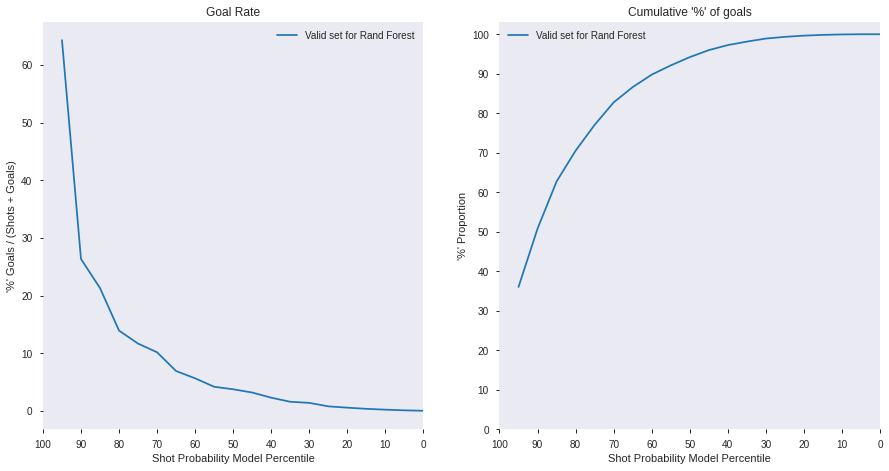

In [226]:
plot_metrics.plot_percentile([y_valid],[y_proba_val],bin_width=5,plot_labels=["Valid set for Rand Forest"])

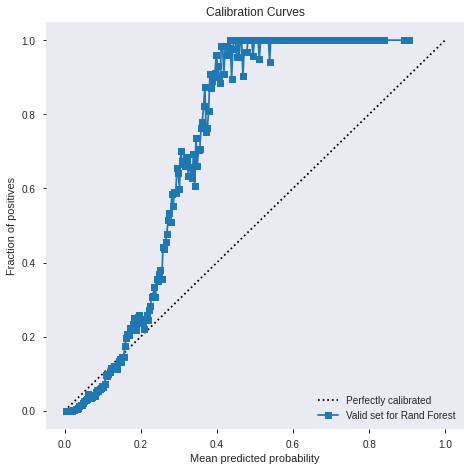

In [227]:
plot_metrics.plot_calibration([y_valid],[y_proba_val],plot_labels=["Valid set for Rand Forest"])

# On test set

In [228]:
y_pred_test  = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)[:,1] # get the proba of having a goal (pred=1)
score_test = model.score(X_test,y_test)
score_test

0.9135335187316737

## Export model

In [229]:
weights_dir = "../ift6758/models/weights"
experiment = "Random-forest-with-FE2"
predscore_val_dict={}

In [230]:
import joblib

predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['true_test_label']=y_test
predscore_val_dict[experiment]['proba']=y_proba_test
predscore_val_dict[experiment]['prediction']=y_pred_test

## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(model,filename)

['../ift6758/models/weights/Random-forest-with-FE2.pkl']

In [231]:
exp.log_model("Random Forest", "../ift6758/models/weights/Random-forest-with-FE2.pkl")

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=14865ec493a2444aa508c546faf7abec&experimentKey=2de74906d5ad42c0913ded110a44d306',
 'assetId': '14865ec493a2444aa508c546faf7abec',
 'web': 'https://www.comet.ml/api/asset/download?assetId=14865ec493a2444aa508c546faf7abec&experimentKey=2de74906d5ad42c0913ded110a44d306'}

# Plot

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    216808
           1       1.00      0.03      0.06     21238

    accuracy                           0.91    238046
   macro avg       0.96      0.52      0.51    238046
weighted avg       0.92      0.91      0.87    238046



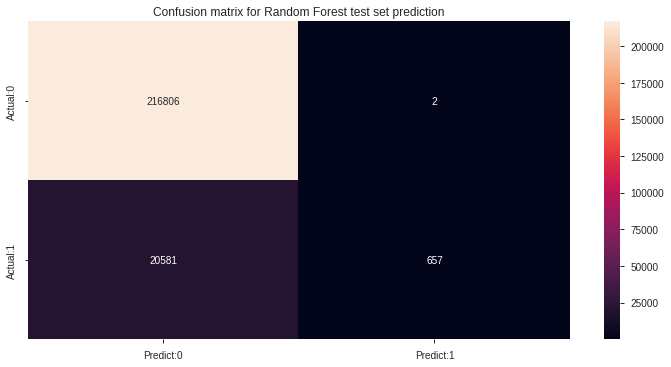

In [236]:
from ift6758.metrics import plot_metrics

plot_metrics.plotConfusion(y_test,y_pred_test, title='Confusion matrix for Random Forest test set prediction')

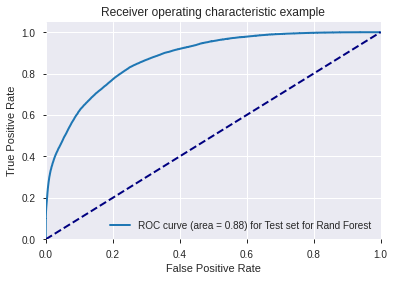

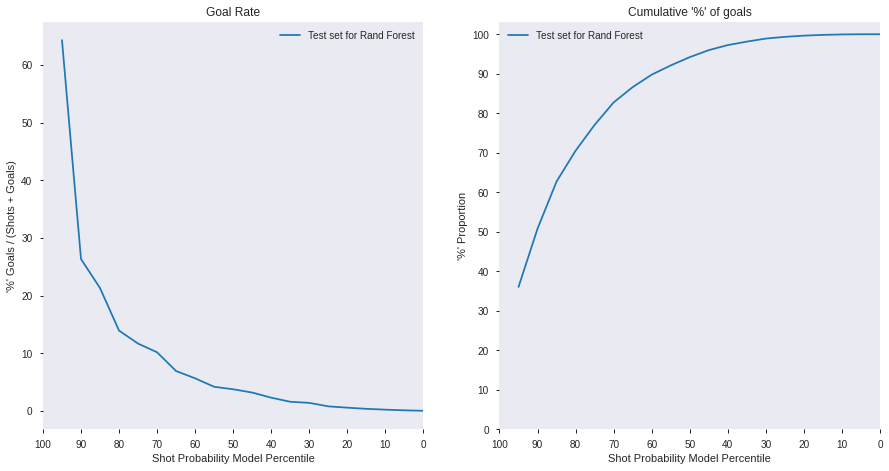

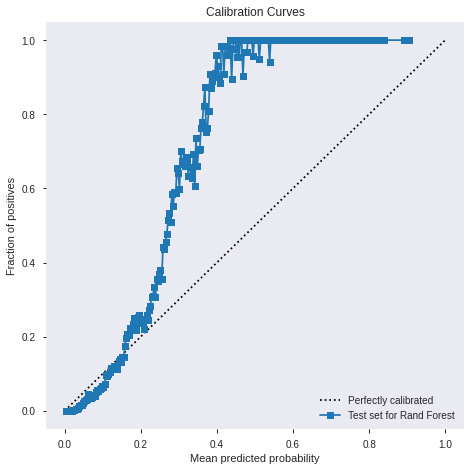

In [237]:
plot_metrics.plot_roc([y_test],[y_proba_test],["Test set for Rand Forest"])
plot_metrics.plot_percentile([y_test],[y_proba_test],bin_width=5,plot_labels=["Test set for Rand Forest"])
plot_metrics.plot_calibration([y_test],[y_proba_test],plot_labels=["Test set for Rand Forest"])

In [241]:
X_valid

,gameSeconds,timeFromLastEvent,gamePeriod,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot
42931,-1.189879,-0.510432,-1.220910,-0.309608,3.088922,1.367956,0,0.759210,-0.363797,0,0,0,0,0,0,1
226469,-0.110015,-0.375125,-0.037123,2.443040,-1.133259,-0.374226,0,-0.348500,-0.363797,0,0,0,0,0,1,0
35110,-0.940017,-0.713393,1.146664,0.653075,0.471498,-0.694141,0,-0.197171,-0.363797,0,0,0,0,0,0,1
130673,0.636699,-0.307472,1.146664,-0.116362,-0.723571,-0.884944,0,-0.601367,-0.363797,0,1,0,0,0,0,0
201795,1.015801,-0.239818,-1.220910,0.638387,1.429149,-1.029138,0,-0.672302,-0.363797,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39437,-0.362749,0.707331,-0.037123,1.321477,-0.634899,-1.236343,1,-0.773582,0.275091,0,0,0,0,0,0,1
173797,-1.603444,-0.713393,-1.220910,-0.106667,-0.660781,0.652204,0,1.035181,-0.363797,0,0,0,0,0,0,1
240024,-0.718874,-0.848700,1.146664,1.602831,-0.272190,0.034419,0,1.311276,-0.363797,0,0,0,1,0,0,0
215622,1.067496,-0.916354,1.146664,-0.024079,-0.944599,-0.867891,1,0.298462,2.819803,0,0,0,0,0,0,1


In [243]:
X_test

,gameSeconds,timeFromLastEvent,gamePeriod,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot
42931,-1.189879,-0.510432,-1.220910,-0.309608,3.088922,1.367956,0,0.759210,-0.363797,0,0,0,0,0,0,1
226469,-0.110015,-0.375125,-0.037123,2.443040,-1.133259,-0.374226,0,-0.348500,-0.363797,0,0,0,0,0,1,0
35110,-0.940017,-0.713393,1.146664,0.653075,0.471498,-0.694141,0,-0.197171,-0.363797,0,0,0,0,0,0,1
130673,0.636699,-0.307472,1.146664,-0.116362,-0.723571,-0.884944,0,-0.601367,-0.363797,0,1,0,0,0,0,0
201795,1.015801,-0.239818,-1.220910,0.638387,1.429149,-1.029138,0,-0.672302,-0.363797,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39437,-0.362749,0.707331,-0.037123,1.321477,-0.634899,-1.236343,1,-0.773582,0.275091,0,0,0,0,0,0,1
173797,-1.603444,-0.713393,-1.220910,-0.106667,-0.660781,0.652204,0,1.035181,-0.363797,0,0,0,0,0,0,1
240024,-0.718874,-0.848700,1.146664,1.602831,-0.272190,0.034419,0,1.311276,-0.363797,0,0,0,1,0,0,0
215622,1.067496,-0.916354,1.146664,-0.024079,-0.944599,-0.867891,1,0.298462,2.819803,0,0,0,0,0,0,1


In [244]:
exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/2de74906d5ad42c0913ded110a44d306
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FM0rph3e%2Fift6758-project-main%2Fblob%2Fmain%2Fnotebooks%2Ftry_your_best_shot.ipynb
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     class_weight             : 1
COMET INFO:     copy                     : True
COMET INFO:     criterion                : entropy
COMET INFO:     max_depth                : 14
COMET INFO:     max_features             : auto
COMET INFO:     max_leaf_nodes           : 1
COMET INFO:     max_samples              : 1
COMET INFO:     min_impurity_decrease    